In [2]:
from fem.definitions import local_stiffness_matrix, local_mass_matrix
from fem.construction import construct_global_stiffness_matrix, construct_global_mass_matrix
from fem.system import solve_system

#from obj.parser import parse_obj
#from obj.transforms import to_numpy_array, enforce_fem_order
from obj.generate import rectangular_domain

from math import sin, pi, cos,sqrt

import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

#### Load in the mesh

In [20]:
N = 3
obj = rectangular_domain(N=N)
#obj

#### Set parameters and create domain

In [21]:
parameters = (1, [0, 0], 0)

def known_nodes(v):
    return abs(v[0]) == 1 or abs(v[1]) == 1 or v[0] == 0 or v[1] == 0

domain = {'obj': obj, 'known_nodes': known_nodes}

#### Construct the global system

In [22]:
A = construct_global_stiffness_matrix(domain, parameters)
M = construct_global_mass_matrix(domain, parameters)

def exact(x, y):
    return sin(pi * x) * sin(pi * y)

def f (x, y):
    return (2*pi**2) * (sin(pi * x)) * (sin(pi * y)) #+ pi*cos(pi * x) * sin(pi * y)

verts = [(x,y) for x, y, _ in obj['vertices']]
F = np.array([f(x,y) for x, y in verts])

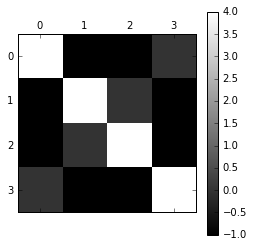

In [23]:
plt.matshow(A.A, cmap=plt.cm.gray)
plt.colorbar()

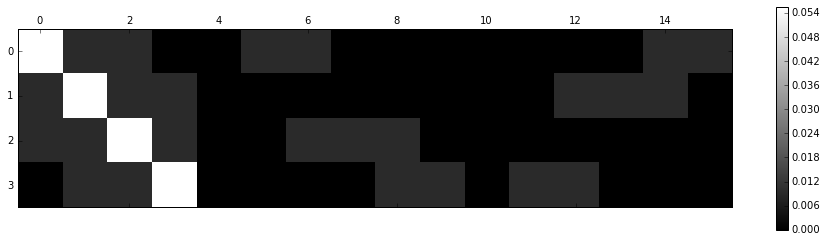

In [24]:
plt.matshow(M.A, cmap=cm.gray)
plt.colorbar()

In [25]:
M.shape

(4, 16)

In [26]:
M*F

array([ 1.09662271,  1.23370055,  1.23370055,  1.09662271])

#### Solve it

In [53]:
u = np.linalg.solve(A.A, M*F)
u = np.append(u, [0.0 for _ in range(4*N)])
len(u)

289

#### Plot results and compare with the actual solution

In [54]:
xs = [x for x, _ in verts]
ys = [y for _, y in verts]

co = list(zip(xs,ys,u))

xi = list(set(xs))
xi.sort()
yi = list(set(ys))
yi.sort()

coords = [(xi.index(x), yi.index(y), z) for x, y, z in co]

zs = np.matrix(np.identity(N+1))

for x, y, z in coords:
    zs[x, y] = z
    
results = solve_system(parameters, known_nodes, f, N, exact)

(17, 17)


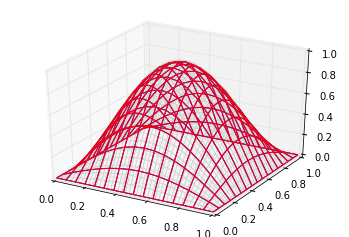

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = np.linspace(0,1,128)
Y = np.linspace(0,1,128)
X, Y = np.meshgrid(X, Y)
Z = np.sin(pi * X) * np.sin(pi * Y)
ax.plot_wireframe(X, Y, Z, rstride=3, cstride=3, color='lightgrey')


Xs, Ys = np.meshgrid(xi, yi)
xs, ys = np.meshgrid(*results['grid'])
#Zs = (Xs + Ys) - (Xs + Ys)

ax.plot_wireframe(Xs, Ys, zs, color='blue')
ax.plot_wireframe(xs, ys, results['U'], color='red')
#ax.scatter(xs, ys, u, c='r', marker='^')

In [56]:
def L2_error(N, grid, soln, exact):
    """
    Given a grid and the approximate solution, calculate the L^2 error
    """
    xs, ys = grid
    
    err = 0
    
    for y in ys:
        for x in xs:
            err += (soln[x, y] - exact(x,y))**2
            
    err = (1 / N ** 2) * sqrt(err)
    
    return err
    

In [57]:
print(xi)
print(results['grid'][0])
print(L2_error(N, (xi, yi), zs, exact))
print(L2_error(N, results['grid'], results['U'], exact))

[0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0]
[0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0]
0.0312503391896088
0.0312503391896088


In [59]:
print(results['U'][4,4])
exact(0.25, 0.25)

0.494170817874


0.4999999999999999